In [10]:
import numpy as np
import pandas as pd

from scipy.sparse import coo_matrix

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score

import matplotlib.pylab as plt

np.random.seed(42)

In [11]:
def load_train(fn):
    row = []
    col = []
    val = []
    
    with open(fn) as f:
        for i, line in enumerate(f):
            t = line.strip().split(' ')
        
            for v in range(len(t) // 2):
                row.append(i)
                col.append(int(t[2 * v]))
                val.append(int(t[2 * v + 1]))
            
    row = np.array(row)
    col = np.array(col)
    val = np.array(val)
    
    coo = coo_matrix((val, (row, col)))
    
    return coo.tocsr()

def top_word(X, top=5000):
    
    freq = np.sum(X, axis=0)
    
    idx = np.argsort(-np.squeeze(freq.flat))
    
    return X[:, idx[:top]]


def post_process(label):
    
    n_noise = np.sum(label == -1)
    label[label == -1] = len(np.unique(label))
    
    return label, n_noise


def find_elbow(curve):
    """https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    """
    n_pts = len(curve)
    coords = np.vstack((range(n_pts), curve)).T
    np.array([range(n_pts), curve])
    first_pt = coords[0]
    line_vec = coords[-1] - coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = coords - first_pt
    prod = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_pts, 1), axis=1)
    vec_from_first_parallel = np.outer(prod, line_vec_norm)
    vec_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_line ** 2, axis=1))
    idx = np.argmax(dist_to_line)
    
    return idx


def eps_from_kneighbor(X, k_neighbor=4, metric='cosine', plot=False):
    """Estimate eps from k-neighbor distance
    
    X: array_like [n_sample, n_feature]
    pts: array_like 
    metric: distance metric
    """
    
    if metric == 'jaccard':
        dis = pairwise_jaccard(X)
    else:
        dis = pairwise_distances(X, metric=metric)
        
    # find near neighbor point distance
    neighbor_dis = np.sort(dis, axis=-1)

    k_neighbor_dis = neighbor_dis[:, k_neighbor]
    k_neighbor_dis = np.sort(k_neighbor_dis)[::-1]
    
    dd = k_neighbor_dis[k_neighbor_dis > np.mean(k_neighbor_dis)]
    keen_idx = find_elbow(dd)
    eps = dd[keen_idx]
    n_less_eps = np.sum(k_neighbor_dis < eps)
     
    if plot:
        plt.title('{:d}th neighbor esitmate {:.2f} less count {:4d}'.format(k_neighbor, eps, n_less_eps))
        plt.ylabel('distance')
        plt.plot(k_neighbor_dis)
        plt.show()
    
    return eps

    
def pairwise_jaccard(X):
    """Computes the Jaccard distance between the rows of `X`.
    """
    X = X.astype(bool).astype(int)

    intrsct = X.dot(X.T)
    row_sums = intrsct.diagonal()
    unions = row_sums[:,None] + row_sums - intrsct
    dist = 1.0 - intrsct / unions
    return np.array(dist)

In [12]:
class BruteDBSCAN():
    
    def __init__(self, eps=0.5, minPts=5, metric='cosine'):
        
        self.eps = eps
        self.minPts = minPts
        self.metric = metric
        
        self.NOISE = -1
        self.EMPTY = 0
        
        
    def fit_predict(self, X, y=None):
        
        self.labels  = np.ones(X.shape[0], dtype=np.int) * self.EMPTY
        self.C = self.EMPTY
        
        if self.metric == 'jaccard':
            dis_pre_compute = pairwise_jaccard(X)
        else:
            dis_pre_compute = pairwise_distances(X, metric=self.metric)
        
        n_sample = X.shape[0]

        for p_idx in range(n_sample):
        
            # If p is visited go next point
            if self.labels[p_idx] != self.EMPTY:
                continue
            
            # Find neighbors         
            neighbors_idx = self._rangeQuery(dis_pre_compute, p_idx)
        
            # Density check 
            if len(neighbors_idx) < self.minPts:
                self.labels[p_idx] = self.NOISE
                continue

            self.C += 1
            self.labels[p_idx] = self.C
        
            # exlucde p from seed set
            seed = set(neighbors_idx.flat) - set([p_idx])
            seed = np.array(list(seed))
            self._growCluster(dis_pre_compute, seed)
        
        return self.labels.copy()
        
        
    def _growCluster(self, X_dis, seed):
        
        s = 0
        while s < len(seed):
            q_idx = seed[s]
            if self.labels[q_idx] == self.NOISE:
                self.labels[q_idx] = self.C
        
            if self.labels[q_idx] == self.EMPTY:
                self.labels[q_idx] = self.C
            
                # grow seed set
                branch_neigbors_idx = self._rangeQuery(X_dis, q_idx)
                if len(branch_neigbors_idx) >= self.minPts:
                    seed = np.concatenate([seed, branch_neigbors_idx])
            
            s += 1
    
    def _rangeQuery(self, X_dis, idx):
        dis = X_dis[idx]
        neighbors_idx, = np.where(dis.ravel() < self.eps)
    
        return neighbors_idx

In [13]:
X_train = load_train('data/train.dat.txt')

In [14]:
var = VarianceThreshold()
X_var = var.fit_transform(X_train)

In [15]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_var)

In [16]:
print(X_train.shape)
print(X_var.shape)
print(X_tfidf.shape)
metric = 'cosine'

(8580, 126356)
(8580, 27673)
(8580, 27673)


TSVD: 10


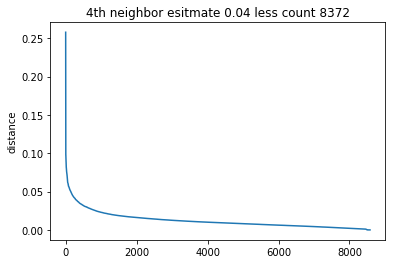

TSVD: 15


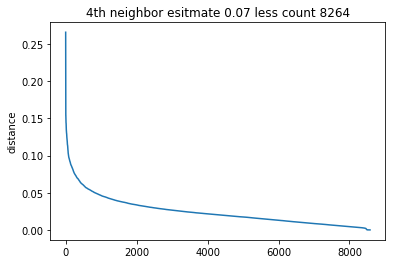

tfidf_svd_015_eps_0p07_min_075_nclsss_11_score_0p2233
[   0 4613  549  502  262   87  150  380  343  323  387  984]
tfidf_svd_015_eps_0p07_min_080_nclsss_11_score_0p2215
[   0 4600  542  502  260  150   86  376  344  315  388 1017]
tfidf_svd_015_eps_0p07_min_085_nclsss_10_score_0p2142
[   0 4568  501  502  258  150  321  343  314  385 1238]
tfidf_svd_015_eps_0p07_min_090_nclsss_10_score_0p2122
[   0 4534  498  502  252  150  321  342  314  385 1282]
tfidf_svd_015_eps_0p07_min_095_nclsss_10_score_0p2100
[   0 4498  498  501  252  150  321  336  314  383 1327]
tfidf_svd_015_eps_0p07_min_100_nclsss_10_score_0p2017
[   0 4420  500  507  240  150  307  335  314  383 1424]
TSVD: 20


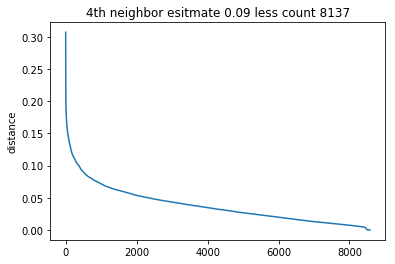

tfidf_svd_020_eps_0p09_min_070_nclsss_12_score_0p2253
[   0 2018  445  222  106  151 1999  273  322  344  707  378 1615]
tfidf_svd_020_eps_0p09_min_075_nclsss_14_score_0p2663
[   0 1997  214  444  105  151  413  261  319  344  320  376 1541  387
 1708]
tfidf_svd_020_eps_0p09_min_080_nclsss_14_score_0p2588
[   0 1927  208  445   93  152  357  257  319  341  320  371 1463  386
 1941]
tfidf_svd_020_eps_0p09_min_085_nclsss_16_score_0p2828
[   0 1398  508  206  207  226  151   92  339  240  319  341  320  371
 1435  384 2043]
tfidf_svd_020_eps_0p09_min_090_nclsss_16_score_0p2762
[   0 1385  507  201  207  213  151   92  313  232  308  337  320  370
 1407  384 2153]
tfidf_svd_020_eps_0p09_min_095_nclsss_15_score_0p2640
[   0 1334  512  197  203  214  151  228  307  332  281  319  370 1366
  384 2382]
tfidf_svd_020_eps_0p09_min_100_nclsss_16_score_0p2750
[   0  466  513  195  203  832  213  150  228  307  331  244  319  370
 1329  383 2497]
TSVD: 30


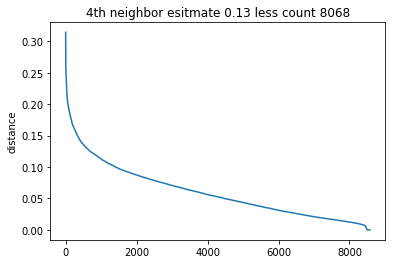

tfidf_svd_030_eps_0p13_min_060_nclsss_18_score_0p1545
[   0 2103  443  213  110  155  124  135   75  228  357  349  719   62
 1223   56   89  340 1799]
tfidf_svd_030_eps_0p13_min_065_nclsss_17_score_0p1616
[   0 2025  442  210  110  157  133  117  222  343  351  719   62 1207
   56   80  337 2009]
tfidf_svd_030_eps_0p13_min_070_nclsss_14_score_0p2196
[   0 1960  437  206  109  157  207  314  350  122  719  103 1134  327
 2435]
tfidf_svd_030_eps_0p13_min_075_nclsss_15_score_0p2560
[   0 1403  550  431  206  108  157  207  314  347  115  718   92 1105
  327 2500]
tfidf_svd_030_eps_0p13_min_080_nclsss_16_score_0p2472
[   0 1355  546  235  203  184  108  157  207  305  346  114  718   81
 1040  321 2660]
tfidf_svd_030_eps_0p13_min_085_nclsss_16_score_0p2306
[   0 1344  546  232  199  184  108  157  206  301  340  108  716  901
  122  318 2798]
tfidf_svd_030_eps_0p13_min_090_nclsss_16_score_0p2175
[   0 1320  502  195  205  104  190  155  205  301  338  716   95  852
  111  316 2975]
tfidf_

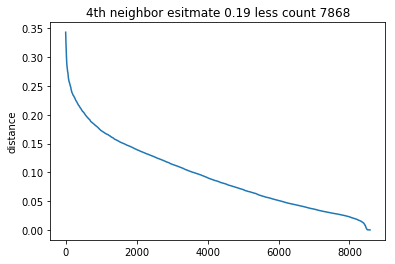

tfidf_svd_050_eps_0p19_min_045_nclsss_15_score_0p1525
[   0  250 1563  473  184  113  457  116 1761  255  725  719  100   85
   40 1739]
tfidf_svd_050_eps_0p19_min_055_nclsss_20_score_0p1622
[   0  192  566  448  183   58  438  791  116  158 1052   54  228  367
  348  714  100  181   55  114 2417]
tfidf_svd_050_eps_0p19_min_060_nclsss_18_score_0p1837
[   0  157  564  185  409  385  797  116  158  905  125  206  364  346
  709  100  172   74 2808]
tfidf_svd_050_eps_0p19_min_065_nclsss_17_score_0p1833
[   0  129  177  386  556  334  788  116  158  886  125  206  364  345
  708  100  155 3047]
tfidf_svd_050_eps_0p19_min_070_nclsss_18_score_0p1821
[   0  120  172  553  333  781  116  158   94  865  205  310  358  123
  706  101  149  281 3155]
tfidf_svd_050_eps_0p19_min_075_nclsss_19_score_0p1702
[   0  112  165  551  200  774  116  130  158  852  205  299  355  122
  706   99  145  318   40 3233]
tfidf_svd_050_eps_0p19_min_080_nclsss_20_score_0p1880
[   0  160  529  200  772  115  121  15

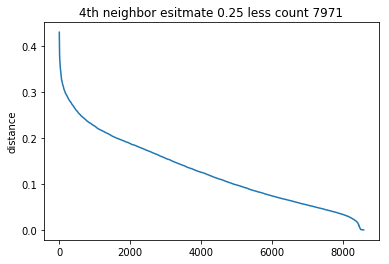

tfidf_svd_070_eps_0p25_min_080_nclsss_14_score_0p1628
[   0  191  553  383  744  119  161  126  207  654  135  707  425  891
 3284]
tfidf_svd_070_eps_0p25_min_085_nclsss_16_score_0p1825
[   0  180  531  380  740  111  161  126  207  286  360  129  706  101
  876  321 3365]
tfidf_svd_070_eps_0p25_min_090_nclsss_19_score_0p1693
[   0  175  529  262  729  101  163   95  112  199  285  359  118  702
  611  143  102   96  321 3478]


In [17]:
for n_comp in [10, 15, 20, 30, 50, 70]:
    
    print('TSVD: {:d}'.format(n_comp))
    
    tsvd = TruncatedSVD(n_components=n_comp, n_iter=500, random_state=4)
    X_svd = tsvd.fit_transform(X_tfidf)
    eps = eps_from_kneighbor(X_svd, plot=True)
    
    for p in np.arange(5, 105, 5):

        db = BruteDBSCAN(eps=eps, minPts=p)
        label = db.fit_predict(X_svd)
        score = silhouette_score(X_svd, label, metric)
        label, n_noise = post_process(label)
        n_class = len(np.unique(label))

        if score > 0.15:
            
            eps_str = '{:.2f}'.format(eps).replace('.', 'p')
            score_str= '{:.4f}'.format(score).replace('.', 'p')
            fn = 'tfidf_svd_{:03d}_eps_{:}_min_{:03d}_nclsss_{:02d}_score_{:}'.format(
                n_comp, eps_str, p, n_class, score_str)
            
            print(fn)
            print(np.bincount(label))
                
            df = pd.DataFrame(data=label)
            df.to_csv('{}.txt'.format(fn), header=None, index=None)
            
            print("="*20)

In [20]:
pts = np.arange(2, 23, 2)
cls = np.zeros(len(pts))

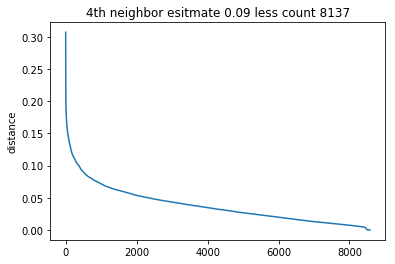

In [19]:
tsvd = TruncatedSVD(n_components=20, n_iter=500, random_state=4)
X_svd = tsvd.fit_transform(X_tfidf)
eps = eps_from_kneighbor(X_svd, plot=True)

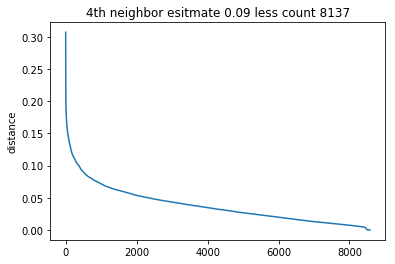

In [42]:
fig = plt.figure()
eps = eps_from_kneighbor(X_svd, plot=True)
fig.savefig('kneighbor_graph.png')

In [21]:
for idx, p in enumerate(pts):
    db = BruteDBSCAN(eps=eps, minPts=p)
    label = db.fit_predict(X_svd)
    label, n_noise = post_process(label)
    n_class = len(np.unique(label))
    
    cls[idx] = n_class

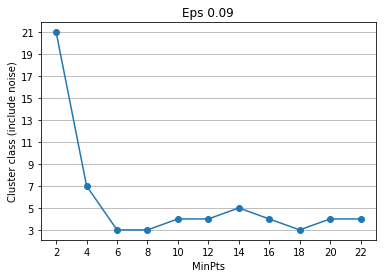

In [39]:
plt.title('Eps {:.2f}'.format(eps))
plt.xlabel('MinPts')
plt.ylabel('Cluster class (include noise)')
plt.xticks(pts)
plt.yticks(np.arange(1, np.max(cls) + 1, 2))
plt.grid(axis='y')
plt.plot(pts, cls, marker='o')
plt.savefig('eps_minpts_eval.png')